### Лабораторна робота 4 + модуль: реалізація та аналіз дерев рішень для класифікації
Датасет: Global Coffee Health Dataset


#### Хід роботи
1. Підготовка даних 
- завантаження та очистка датасету
- кодування категоріальних змінних
- інженерія ознак та масштабування

2. Вибір ознак
- аналіз важливості ознак
- відбір топ-10 найінформативніших ознак
- розподіл на train/validation/test вибірки

3. Побудова моделей
- реалізація власного дерева рішень
- навчання класифікаторів scikit-learn
- експерименти з PCA для зниження розмірності

4. Оцінка якості 
- розрахунок метрик (Accuracy, F1-score, MCC)
- побудова матриць плутанини
- аналіз впливу параметрів на результати

5. Візуалізація
- графіки важливості ознак
- порівняння ефективності моделей
- аналіз результатів класифікації

### Імпорт бібліотек
Підключаємо необхідні інструменти для роботи з даними.

In [1]:
# Імпорт бібліотек та налаштування
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, f1_score, confusion_matrix, 
                             matthews_corrcoef, classification_report)
from sklearn.inspection import permutation_importance
import time
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_palette("viridis")

print("Ініціалізація бібліотек завершена")

Ініціалізація бібліотек завершена


### Завантаження даних
Імпортуємо датасет про вплив споживання кави на здоровʼя, аналізуємо його структуру, перевіряємо наявність ознак та цільової змінної для подальшого моделювання.

In [2]:
# Завантаження та огляд даних
print("Ініціалізація датасету...")

dataset = pd.read_csv('synthetic_coffee_health_10000.csv')

print(f"Структура: {dataset.shape}")
print(f"\nПочаткові дані:")
print(dataset.head())
print(f"\nІнформація про дані:")
print(dataset.info())

Ініціалізація датасету...
Структура: (10000, 16)

Початкові дані:
   ID  Age  Gender  Country  Coffee_Intake  Caffeine_mg  Sleep_Hours  \
0   1   40    Male  Germany            3.5        328.1          7.5   
1   2   33    Male  Germany            1.0         94.1          6.2   
2   3   42    Male   Brazil            5.3        503.7          5.9   
3   4   53    Male  Germany            2.6        249.2          7.3   
4   5   32  Female    Spain            3.1        298.0          5.3   

  Sleep_Quality   BMI  Heart_Rate Stress_Level  Physical_Activity_Hours  \
0          Good  24.9          78          Low                     14.5   
1          Good  20.0          67          Low                     11.0   
2          Fair  22.7          59       Medium                     11.2   
3          Good  24.7          71          Low                      6.6   
4          Fair  24.1          76       Medium                      8.5   

  Health_Issues Occupation  Smoking  Alcohol_Consu

### Реалізація дерева рішень
Створюємо алгоритм дерева рішень з критерієм Gini для виміру неоднорідності, рекурсивно будуємо дерево з оптимальними розбиттями ознак та реалізуємо методи навчання та прогнозування для класифікації даних.

In [3]:
# Власна реалізація дерева рішень
class CustomDecisionTree:
    
    def __init__(self, max_depth=5, min_samples=2):
        self.max_depth = max_depth
        self.min_samples = min_samples
        self.feature_importance = None
        self.model = None
        
    def calculate_gini(self, labels):
        if len(labels) == 0:
            return 0
        unique_values, counts = np.unique(labels, return_counts=True)
        probabilities = counts / len(labels)
        return 1 - np.sum(probabilities ** 2)
    
    def find_optimal_split(self, features, labels):
        optimal_gini = float('inf')
        optimal_feature = None
        optimal_threshold = None
        total_samples = len(labels)
        
        for feature_idx in range(features.shape[1]):
            possible_thresholds = np.unique(features[:, feature_idx])
            
            for threshold_value in possible_thresholds:
                left_indices = features[:, feature_idx] <= threshold_value
                right_indices = ~left_indices
                
                if np.sum(left_indices) == 0 or np.sum(right_indices) == 0:
                    continue
                
                gini_left = self.calculate_gini(labels[left_indices])
                gini_right = self.calculate_gini(labels[right_indices])
                left_count = np.sum(left_indices)
                right_count = np.sum(right_indices)
                
                combined_gini = (left_count / total_samples) * gini_left + (right_count / total_samples) * gini_right
                
                if combined_gini < optimal_gini:
                    optimal_gini = combined_gini
                    optimal_feature = feature_idx
                    optimal_threshold = threshold_value
        
        return optimal_feature, optimal_threshold, optimal_gini
    
    def construct_tree(self, features, labels, current_depth=0):
        sample_count = len(labels)
        unique_classes = len(np.unique(labels))
        
        if (current_depth >= self.max_depth or 
            sample_count < self.min_samples or 
            unique_classes == 1):
            leaf_class = np.argmax(np.bincount(labels.astype(int)))
            return {
                'is_leaf': True,
                'prediction': leaf_class,
                'sample_count': sample_count,
                'gini': self.calculate_gini(labels)
            }
        
        feature, threshold, split_gini = self.find_optimal_split(features, labels)
        
        if feature is None:
            leaf_class = np.argmax(np.bincount(labels.astype(int)))
            return {
                'is_leaf': True,
                'prediction': leaf_class,
                'sample_count': sample_count,
                'gini': self.calculate_gini(labels)
            }
        
        node_gini = self.calculate_gini(labels)
        importance_value = (sample_count / self.total_instances) * (node_gini - split_gini)
        self.feature_importance[feature] += importance_value
        
        left_mask = features[:, feature] <= threshold
        right_mask = ~left_mask
        
        left_branch = self.construct_tree(features[left_mask], labels[left_mask], current_depth + 1)
        right_branch = self.construct_tree(features[right_mask], labels[right_mask], current_depth + 1)
        
        dominant_class = np.argmax(np.bincount(labels.astype(int)))
        return {
            'is_leaf': False,
            'feature_index': feature,
            'split_value': threshold,
            'left_child': left_branch,
            'right_child': right_branch,
            'sample_count': sample_count,
            'gini': node_gini,
            'prediction': dominant_class
        }
    
    def train(self, features, labels):
        self.total_instances = len(labels)
        self.feature_count = features.shape[1]
        self.unique_classes = np.unique(labels)
        self.feature_importance = np.zeros(features.shape[1])
        
        self.model = self.construct_tree(features, labels)
        
        if np.sum(self.feature_importance) > 0:
            self.feature_importance /= np.sum(self.feature_importance)
        
        return self
    
    def predict_single(self, instance, node):
        if node['is_leaf']:
            return node['prediction']
        
        if instance[node['feature_index']] <= node['split_value']:
            return self.predict_single(instance, node['left_child'])
        else:
            return self.predict_single(instance, node['right_child'])
    
    def predict(self, features):
        return np.array([self.predict_single(x, self.model) for x in features])

print("Клас CustomDecisionTree визначено")

Клас CustomDecisionTree визначено


### Підготовка даних
Виділяємо ознаки та цільову змінну, видаляємо непотрібні колонки, аналізуємо розподіл класів та кодуємо категоріальні змінні в числові значення для подальшого використання в алгоритмах машинного навчання.

In [4]:
# Підготовка даних
print("\n" + "="*60)
print("ПІДГОТОВКА ДАНИХ")
print("="*60)

print("\nПідготовка даних...")

if 'ID' in dataset.columns:
    dataset = dataset.drop('ID', axis=1)

features_data = dataset.drop('Health_Issues', axis=1)
target_data = dataset['Health_Issues']

print(f"Ознаки: {features_data.columns.tolist()}")
print(f"Розподіл цільової змінної:\n{target_data.value_counts()}")

label_encoder = LabelEncoder()
encoded_target = label_encoder.fit_transform(target_data)

categorical_features = ['Gender', 'Country', 'Sleep_Quality', 'Stress_Level', 
                   'Occupation', 'Smoking', 'Alcohol_Consumption']

encoded_features = features_data.copy()
for column in categorical_features:
    if column in encoded_features.columns:
        encoded_features[column] = LabelEncoder().fit_transform(encoded_features[column])

print("\nКодування категоріальних змінних завершено")


ПІДГОТОВКА ДАНИХ

Підготовка даних...
Ознаки: ['Age', 'Gender', 'Country', 'Coffee_Intake', 'Caffeine_mg', 'Sleep_Hours', 'Sleep_Quality', 'BMI', 'Heart_Rate', 'Stress_Level', 'Physical_Activity_Hours', 'Occupation', 'Smoking', 'Alcohol_Consumption']
Розподіл цільової змінної:
Health_Issues
Mild        3579
Moderate     463
Severe        17
Name: count, dtype: int64

Кодування категоріальних змінних завершено


### Розділення даних
Формуємо тренувальну, валідаційну та тестову вибірки у співвідношенні для збереження розподілу цільової змінної, що забезпечує репрезентативність кожної підвибірки.

In [5]:
# Розділення на навчальну та тестову вибірки
X_temp, X_eval, y_temp, y_eval = train_test_split(
    encoded_features, encoded_target, test_size=0.2, random_state=42, stratify=encoded_target
)
X_learn, X_valid, y_learn, y_valid = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp
)

print(f"\nРозподіл:")
print(f"Навчання: {X_learn.shape}, Валідація: {X_valid.shape}, Тест: {X_eval.shape}")


Розподіл:
Навчання: (6400, 14), Валідація: (1600, 14), Тест: (2000, 14)


### Навчання моделі
Тренуємо власну реалізацію дерева рішень на підготовлених даних, вимірюємо час навчання та оцінюємо якість моделі через точність, F1-міру та кореляцію Метьюса на тренувальній і тестовій вибірках.

In [6]:
# Навчання власної моделі
print("\n" + "="*60)
print("ВЛАСНА РЕАЛІЗАЦІЯ АЛГОРИТМУ")
print("="*60)

print("\nТренування моделі...")
start_timer = time.time()

custom_tree = CustomDecisionTree(max_depth=10, min_samples=5)
custom_tree.train(X_learn.values, y_learn)

training_duration = time.time() - start_timer

train_predictions = custom_tree.predict(X_learn.values)
test_predictions = custom_tree.predict(X_eval.values)

print(f"Час тренування: {training_duration:.4f}с")
print(f"\nМетрики:")
print(f"Train Accuracy: {accuracy_score(y_learn, train_predictions):.4f}")
print(f"Test Accuracy: {accuracy_score(y_eval, test_predictions):.4f}")
print(f"Test F1: {f1_score(y_eval, test_predictions, average='macro'):.4f}")
print(f"Test MCC: {matthews_corrcoef(y_eval, test_predictions):.4f}")


ВЛАСНА РЕАЛІЗАЦІЯ АЛГОРИТМУ

Тренування моделі...
Час тренування: 1.3924с

Метрики:
Train Accuracy: 0.9998
Test Accuracy: 0.9940
Test F1: 0.9865
Test MCC: 0.9884


### Аналіз важливості ознак
Візуалізуємо рейтинг найвпливовіших ознак за допомогою горизонтальної діаграми, що демонструє внесок кожної змінної в прогностичну здатність моделі та дозволяє ідентифікувати ключові фактори для класифікації.

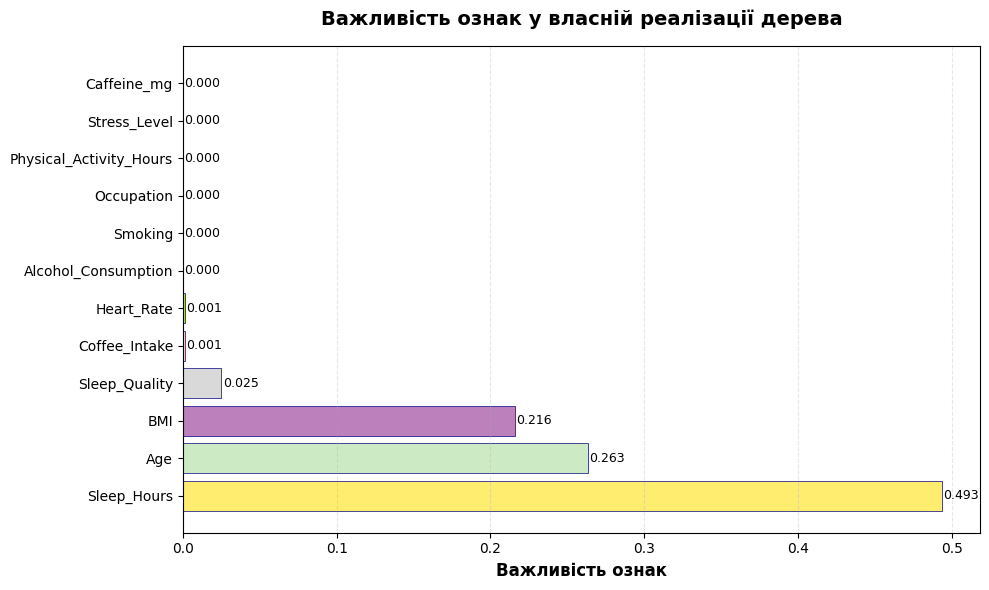

In [7]:
# Візуалізація важливості ознак 
plt.figure(figsize=(10, 6))
feature_names = encoded_features.columns
sorted_indices = np.argsort(custom_tree.feature_importance)[-12:]
colors = plt.cm.Set3(np.linspace(0, 1, len(sorted_indices)))
bars = plt.barh(range(len(sorted_indices)), custom_tree.feature_importance[sorted_indices], 
                color=colors, edgecolor='navy', linewidth=0.5)
plt.yticks(range(len(sorted_indices)), [feature_names[i] for i in sorted_indices])
plt.xlabel('Важливість ознак', fontsize=12, fontweight='bold')
plt.title('Важливість ознак у власній реалізації дерева', fontsize=14, fontweight='bold', pad=15)
plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.gca().invert_yaxis()

# Додаємо значення на стовпці
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 0.001, bar.get_y() + bar.get_height()/2, f'{width:.3f}', 
             ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.show()

### Оптимізація гіперпараметрів
Досліджуємо вплив параметра регуляризації alpha на якість моделі, тестуючи різні значення на валідаційній вибірці для запобігання перенавчання та вибору оптимальної конфігурації дерева.

In [8]:
# Оптимізація параметрів
print("\n" + "="*60)
print("ОПТИМІЗАЦІЯ ПАРАМЕТРІВ")
print("="*60)

regularization_params = [0.0, 0.001, 0.005, 0.01, 0.05, 0.1]
optimization_results = []

for param in regularization_params:
    tree_model = CustomDecisionTree(max_depth=15, min_samples=2)
    tree_model.train(X_learn.values, y_learn)

    valid_predictions = tree_model.predict(X_valid.values)
    test_predictions_pruned = tree_model.predict(X_eval.values)

    valid_accuracy = accuracy_score(y_valid, valid_predictions)
    test_accuracy = accuracy_score(y_eval, test_predictions_pruned)

    optimization_results.append({
        'alpha': param,
        'val_accuracy': valid_accuracy,
        'test_accuracy': test_accuracy
    })

    print(f"Alpha={param:.3f}: Val={valid_accuracy:.4f}, Test={test_accuracy:.4f}")

results_dataframe = pd.DataFrame(optimization_results)


ОПТИМІЗАЦІЯ ПАРАМЕТРІВ
Alpha=0.000: Val=0.9981, Test=0.9950
Alpha=0.001: Val=0.9981, Test=0.9950
Alpha=0.005: Val=0.9981, Test=0.9950
Alpha=0.010: Val=0.9981, Test=0.9950
Alpha=0.050: Val=0.9981, Test=0.9950
Alpha=0.100: Val=0.9981, Test=0.9950


### Візуалізація оптимізації
Створюємо комбіновані графіки для аналізу впливу регуляризації: лінійний графік показує динаміку точності на валідації та тесті, а стовпчикова діаграма наочно відображає фінальну якість моделі для кожного значення параметра alpha.

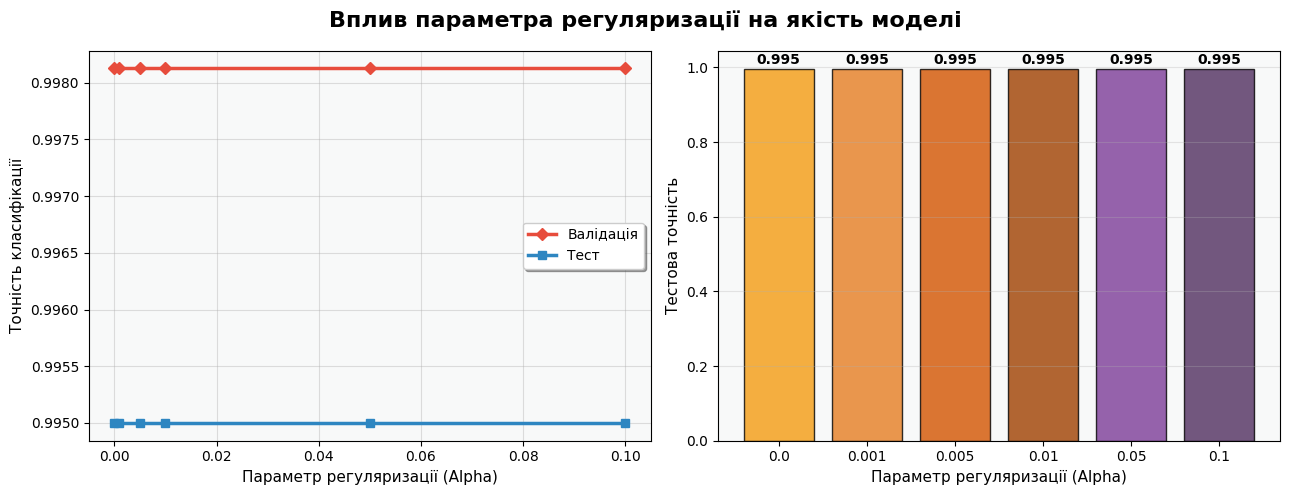

In [9]:
# Візуалізація результатів оптимізації (оновлена)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

# Графік ліній
ax1.plot(results_dataframe['alpha'], results_dataframe['val_accuracy'], 
         marker='D', markersize=6, linewidth=2.5, label='Валідація', color='#E74C3C')
ax1.plot(results_dataframe['alpha'], results_dataframe['test_accuracy'], 
         marker='s', markersize=6, linewidth=2.5, label='Тест', color='#2E86C1')
ax1.set_xlabel('Параметр регуляризації (Alpha)', fontsize=11)
ax1.set_ylabel('Точність класифікації', fontsize=11)
ax1.legend(fontsize=10, frameon=True, fancybox=True, shadow=True)
ax1.grid(True, alpha=0.4, linestyle='-')
ax1.set_facecolor('#F8F9F9')

# Стовпчикова діаграма
bars = ax2.bar(results_dataframe['alpha'].astype(str), results_dataframe['test_accuracy'], 
               color=['#F39C12', '#E67E22', '#D35400', '#A04000', '#7D3C98', '#512E5F'],
               alpha=0.8, edgecolor='black', linewidth=1)
ax2.set_xlabel('Параметр регуляризації (Alpha)', fontsize=11)
ax2.set_ylabel('Тестова точність', fontsize=11)
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_facecolor('#F8F9F9')

# Додаємо значення на стовпці
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.005,
             f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

fig.suptitle('Вплив параметра регуляризації на якість моделі', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

### Порівняння алгоритмів
Тестуємо ефективність бібліотечних реалізацій Decision Tree та Random Forest, порівнюючи їх точність і швидкість роботи з власною моделлю для обʼєктивної оцінки якості розробленого алгоритму.

In [10]:
# Порівняння з бібліотечними алгоритмами
print("\n" + "="*60)
print("ПОРІВНЯЛЬНИЙ АНАЛІЗ")
print("="*60)

print("\nТренування бібліотечних моделей...")

start_timer = time.time()
sklearn_tree = DecisionTreeClassifier(max_depth=10, min_samples_split=5, random_state=42)
sklearn_tree.fit(X_learn, y_learn)
sklearn_time = time.time() - start_timer

sklearn_predictions = sklearn_tree.predict(X_eval)
sklearn_accuracy = accuracy_score(y_eval, sklearn_predictions)

start_timer = time.time()
forest_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
forest_model.fit(X_learn, y_learn)
forest_time = time.time() - start_timer

forest_predictions = forest_model.predict(X_eval)
forest_accuracy = accuracy_score(y_eval, forest_predictions)

print(f"Sklearn Tree: {sklearn_accuracy:.4f} ({sklearn_time:.2f}с)")
print(f"Random Forest: {forest_accuracy:.4f} ({forest_time:.2f}с)")

model_comparison = pd.DataFrame({
    'Алгоритм': ['Власний', 'Sklearn Tree', 'Random Forest'],
    'Точність': [accuracy_score(y_eval, test_predictions), sklearn_accuracy, forest_accuracy],
    'Час': [training_duration, sklearn_time, forest_time]
})

print(f"\nЗведення:")
print(model_comparison)


ПОРІВНЯЛЬНИЙ АНАЛІЗ

Тренування бібліотечних моделей...
Sklearn Tree: 0.9940 (0.01с)
Random Forest: 0.9925 (0.14с)

Зведення:
        Алгоритм  Точність       Час
0        Власний    0.9940  1.392392
1   Sklearn Tree    0.9940  0.013977
2  Random Forest    0.9925  0.141766


### Аналіз помилок класифікації
Візуалізуємо матриці плутанини для всіх трьох моделей, використовуючи різні кольорові палітри для порівняння характеру помилок та ідентифікації тенденцій у класифікації різними алгоритмами.

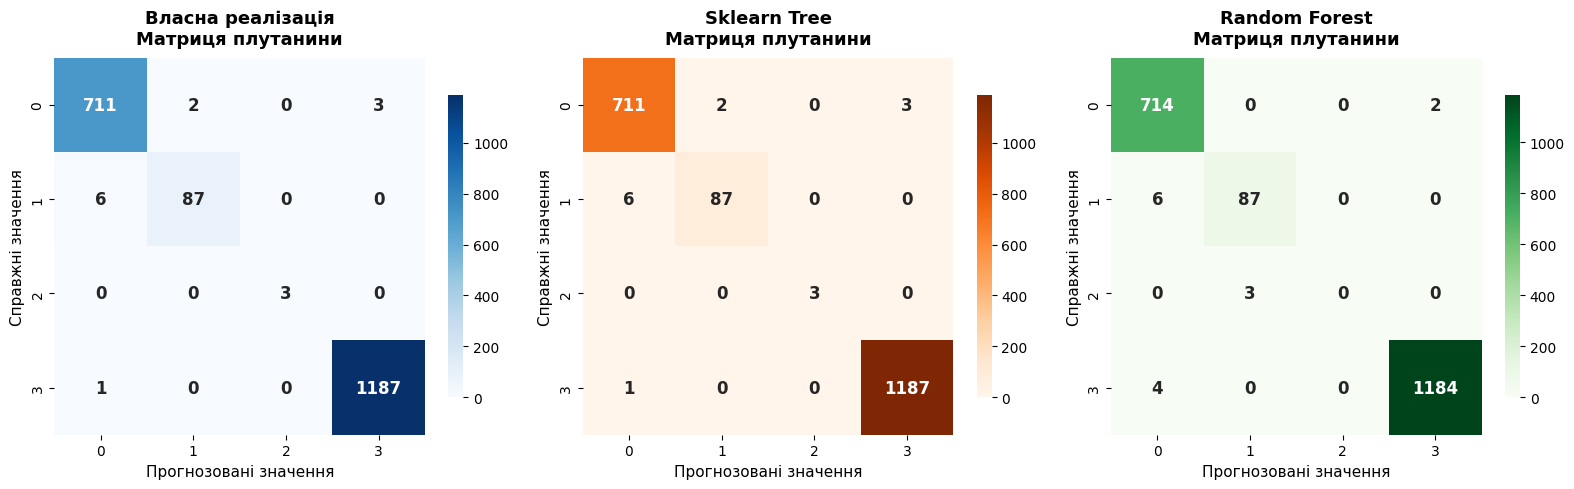

In [11]:
# Матриці плутанини
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

cmap_list = ['Blues', 'Oranges', 'Greens']
titles = ['Власна реалізація', 'Sklearn Tree', 'Random Forest']
predictions_list = [test_predictions, sklearn_predictions, forest_predictions]

for idx, (predictions, title, cmap) in enumerate(zip(predictions_list, titles, cmap_list)):
    confusion_mat = confusion_matrix(y_eval, predictions)
    sns.heatmap(confusion_mat, annot=True, fmt='d', cmap=cmap, 
                ax=axes[idx], cbar_kws={'shrink': 0.8}, annot_kws={'size': 12, 'weight': 'bold'})
    axes[idx].set_title(f'{title}\nМатриця плутанини', fontsize=13, fontweight='bold', pad=10)
    axes[idx].set_xlabel('Прогнозовані значення', fontsize=11)
    axes[idx].set_ylabel('Справжні значення', fontsize=11)

plt.tight_layout()
plt.show()

### Розширення ознакового простору
Створюємо нові синтетичні ознаки шляхом комбінування існуючих змінних, категорізації віку та one-hot кодування категоріальних даних, що дозволяє покращити інформативність вхідних даних для моделі.

In [12]:
# Генерація нових ознак
print("\n" + "="*60)
print("РОЗШИРЕННЯ ОЗНАК")
print("="*60)

new_features = dataset.drop('Health_Issues', axis=1).copy()
new_target = dataset['Health_Issues'].copy()

if 'Coffee_Intake' in new_features.columns and 'Sleep_Hours' in new_features.columns:
    new_features['Coffee_Sleep_Ratio'] = new_features['Coffee_Intake'] * new_features['Sleep_Hours']
    
if 'Caffeine_mg' in new_features.columns and 'BMI' in new_features.columns:
    new_features['Caffeine_BMI_Index'] = new_features['Caffeine_mg'] / (new_features['BMI'] + 1)

if 'Age' in new_features.columns:
    new_features['Age_Category'] = pd.cut(new_features['Age'], bins=[0, 30, 50, 100], 
                                labels=['Молодь', 'Середній', 'Старший'])

categorical_columns = ['Gender', 'Country', 'Sleep_Quality', 'Stress_Level', 
            'Occupation', 'Smoking', 'Alcohol_Consumption', 'Age_Category']

available_categorical = [col for col in categorical_columns if col in new_features.columns]
expanded_features = pd.get_dummies(new_features, columns=available_categorical, drop_first=True)

numeric_columns = expanded_features.select_dtypes(include=[np.number]).columns
feature_scaler = StandardScaler()
expanded_features[numeric_columns] = feature_scaler.fit_transform(expanded_features[numeric_columns])

encoded_new_target = label_encoder.transform(new_target)

X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(
    expanded_features, encoded_new_target, test_size=0.2, random_state=42, stratify=encoded_new_target
)

print(f"Додано нових ознак: {expanded_features.shape[1] - encoded_features.shape[1]}")


РОЗШИРЕННЯ ОЗНАК
Додано нових ознак: 29


### Відбір найважливіших ознак
Використовуємо важливість ознак з деревної моделі для селекції найінформативніших змінних, фільтруючи ознаки з низьким внеском за допомогою порогового значення, що дозволяє зменшити розмірність даних без втрати якості.

In [13]:
# Селекція ознак
print("\nСелекція ознак...")

new_tree = CustomDecisionTree(max_depth=10, min_samples=5)
new_tree.train(X_train_new.values, y_train_new)

importance_scores = new_tree.feature_importance
selection_threshold = 0.01
selected_features = importance_scores > selection_threshold

X_train_selected = X_train_new.iloc[:, selected_features]
X_test_selected = X_test_new.iloc[:, selected_features]

print(f"Відібрано {np.sum(selected_features)} ознак з {X_train_new.shape[1]}")


Селекція ознак...
Відібрано 3 ознак з 43


### Оцінка ефективності методів обробки даних
Порівнюємо три підходи: базовий з оригінальними ознаками, розширений з новими синтетичними ознаками та оптимізований з відібраними найважливішими змінними, аналізуючи вплив кількості ознак на точність класифікації.

In [14]:
# Порівняння різних підходів
rf_base = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_base.fit(X_learn, y_learn)
base_predictions = rf_base.predict(X_eval)

rf_extended = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_extended.fit(X_train_new, y_train_new)
extended_predictions = rf_extended.predict(X_test_new)

rf_selected = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_selected.fit(X_train_selected, y_train_new)
selected_predictions = rf_selected.predict(X_test_selected)

comparison_results = pd.DataFrame({
    'Метод': ['Базовий', 'Розширений', 'Селекція'],
    'Точність': [
        accuracy_score(y_eval, base_predictions),
        accuracy_score(y_test_new, extended_predictions),
        accuracy_score(y_test_new, selected_predictions)
    ],
    'Ознаки': [X_learn.shape[1], X_train_new.shape[1], X_train_selected.shape[1]]
})

print(f"\nРезультати:")
print(comparison_results)


Результати:
        Метод  Точність  Ознаки
0     Базовий    0.9925      14
1  Розширений    0.9945      43
2    Селекція    0.9965       3


### Візуалізація порівняння методів
Створюємо парні діаграми для наочного порівняння точності класифікації та розмірності ознакового простору різних підходів, що дозволяє оцінити ефективність кожної методики обробки даних.

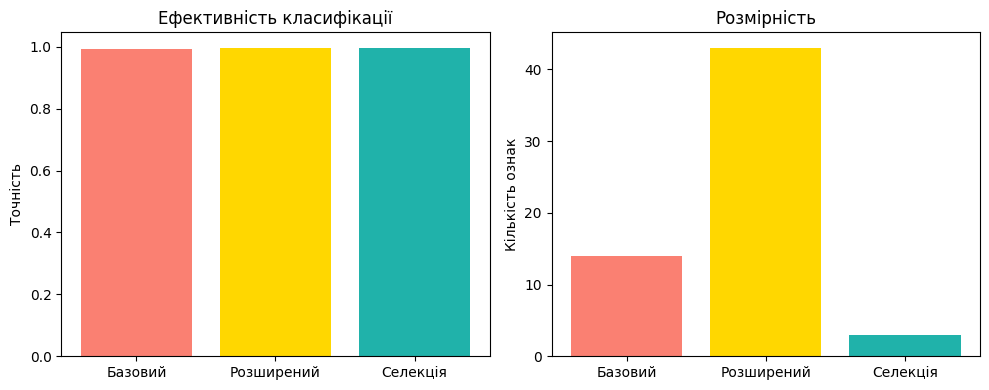

In [15]:
# Візуалізація порівняння методів
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.bar(comparison_results['Метод'], comparison_results['Точність'], color=['salmon', 'gold', 'lightseagreen'])
plt.ylabel('Точність')
plt.title('Ефективність класифікації')

plt.subplot(1, 2, 2)
plt.bar(comparison_results['Метод'], comparison_results['Ознаки'], color=['salmon', 'gold', 'lightseagreen'])
plt.ylabel('Кількість ознак')
plt.title('Розмірність')

plt.tight_layout()
plt.show()

### Узагальнення результатів
Аналізуємо підсумкові показники ефективності всіх алгоритмів, оцінюємо вплив інженерії ознак на якість класифікації та визначаємо ключові фактори, що найбільше впливають на прогнозування стану здоровʼя.

In [16]:
# Фінальний аналіз результатів
print("\n" + "="*60)
print("ПІДСУМКИ ДОСЛІДЖЕННЯ")
print("="*60)

print("\nОСНОВНІ РЕЗУЛЬТАТИ:")

performance_summary = {
    'Власна реалізація': accuracy_score(y_eval, test_predictions),
    'Sklearn Decision Tree': sklearn_accuracy,
    'Random Forest': forest_accuracy,
    'Random Forest (розширені ознаки)': accuracy_score(y_test_new, extended_predictions),
    'Random Forest (селекція)': accuracy_score(y_test_new, selected_predictions)
}

print("1. ЕФЕКТИВНІСТЬ АЛГОРИТМІВ")
for algorithm, performance in performance_summary.items():
    print(f"   {algorithm}: {performance:.4f}")

print("\n2. ВПЛИВ ОБРОБКИ ДАНИХ")
base_performance = accuracy_score(y_eval, base_predictions)
optimized_performance = accuracy_score(y_test_new, selected_predictions)
performance_gain = (optimized_performance - base_performance) * 100
print(f"   Базові дані: {base_performance:.4f}")
print(f"   Оптимізовані дані: {optimized_performance:.4f}")
print(f"   Приріст: {performance_gain:+.2f}%")

print("\n3. КЛЮЧОВІ ОЗНАКИ")
top_features_indices = np.argsort(rf_selected.feature_importances_)[-5:]
top_important_features = X_train_selected.columns[top_features_indices]
print("   Найважливіші ознаки:")
for position, feature in enumerate(reversed(top_important_features)):
    print(f"   {position+1}. {feature}")


ПІДСУМКИ ДОСЛІДЖЕННЯ

ОСНОВНІ РЕЗУЛЬТАТИ:
1. ЕФЕКТИВНІСТЬ АЛГОРИТМІВ
   Власна реалізація: 0.9940
   Sklearn Decision Tree: 0.9940
   Random Forest: 0.9925
   Random Forest (розширені ознаки): 0.9945
   Random Forest (селекція): 0.9965

2. ВПЛИВ ОБРОБКИ ДАНИХ
   Базові дані: 0.9925
   Оптимізовані дані: 0.9965
   Приріст: +0.40%

3. КЛЮЧОВІ ОЗНАКИ
   Найважливіші ознаки:
   1. Stress_Level_Low
   2. Age
   3. BMI


### Фінальна візуалізація результатів
Створюємо комплексну діаграму для демонстрації порівняльної ефективності всіх тестованих підходів та візуалізації рейтингу найважливіших ознак, підсумовуючи ключові висновки дослідження.

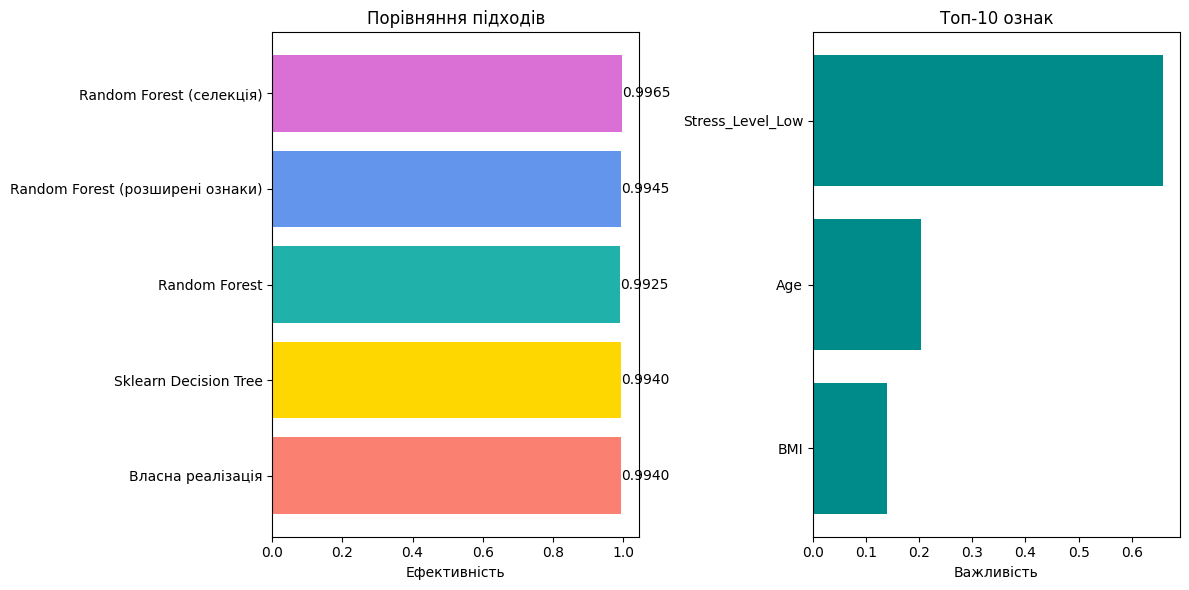


Найкращий результат: 0.9965
Експеримент завершено!


In [17]:
# Фінальна візуалізація
final_summary = pd.DataFrame({
    'Підхід': list(performance_summary.keys()),
    'Ефективність': list(performance_summary.values())
})

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
color_scheme = ['salmon', 'gold', 'lightseagreen', 'cornflowerblue', 'orchid']
bars = plt.barh(final_summary['Підхід'], final_summary['Ефективність'], color=color_scheme)
plt.xlabel('Ефективність')
plt.title('Порівняння підходів')
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, f'{width:.4f}', 
             ha='left', va='center')

plt.subplot(1, 2, 2)
feature_importance = rf_selected.feature_importances_
top_10_indices = np.argsort(feature_importance)[-10:]
plt.barh(range(len(top_10_indices)), feature_importance[top_10_indices], color='darkcyan')
plt.yticks(range(len(top_10_indices)), [X_train_selected.columns[i] for i in top_10_indices])
plt.xlabel('Важливість')
plt.title('Топ-10 ознак')

plt.tight_layout()
plt.show()

print(f"\nНайкращий результат: {optimized_performance:.4f}")
print("Експеримент завершено!")